# Weather Forecasting Models
**Developer**: Jinwoo Oh

---

**Product Manager Accelerator**

The Product Manager Accelerator Program is designed to support PM professionals through every stage of their careers. From students looking for entry-level jobs to Directors looking to take on a leadership role, our program has helped over hundreds of students fulfill their career aspirations. Our Product Manager Accelerator community are ambitious and committed. Through our program they have learnt, honed and developed new PM and leadership skills, giving them a strong foundation for their future endeavors.

Website: https://www.pmaccelerator.io/ | LinkedIn: https://www.linkedin.com/school/pmaccelerator/

## Table of Contents

1. [Imports & Setup](#1.-Imports-&-Setup)
2. [Data Preparation](#2.-Data-Preparation)
3. [Feature Engineering](#3.-Feature-Engineering)
4. [Train/Test Split](#4.-Train/Test-Split)
5. [Model 1: Linear Regression](#5.-Model-1:-Linear-Regression)
6. [Model 2: Random Forest](#6.-Model-2:-Random-Forest)
7. [Model 3: XGBoost / GradientBoosting](#7.-Model-3:-XGBoost-/-GradientBoosting)
8. [Model 4: SARIMA](#8.-Model-4:-SARIMA)
9. [Model 5: Prophet / SARIMA Variant](#9.-Model-5:-Prophet-/-SARIMA-Variant)
10. [Model Comparison](#10.-Model-Comparison)
11. [Ensemble Model](#11.-Ensemble-Model)
12. [Feature Importance](#12.-Feature-Importance)
13. [Conclusions](#13.-Conclusions)

## 1. Imports & Setup

Import all necessary libraries for data manipulation, visualization, machine learning, and time series modeling. Helper functions are defined for consistent evaluation and plotting across all models. If XGBoost or Prophet are unavailable (Python 3.14 compatibility), fallback options are activated automatically.

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Try importing XGBoost
try:
    from xgboost import XGBRegressor
    USE_XGBOOST = True
    print('XGBoost imported successfully.')
except ImportError:
    USE_XGBOOST = False
    print('XGBoost not available. Using GradientBoostingRegressor as fallback.')

# Try importing Prophet
try:
    from prophet import Prophet
    USE_PROPHET = True
    print('Prophet imported successfully.')
except ImportError:
    USE_PROPHET = False
    print('Prophet not available. Using SARIMA variant as fallback.')

# Configuration
warnings.filterwarnings('ignore')
np.random.seed(42)
pd.set_option('display.max_columns', None)
os.makedirs('../outputs/figures', exist_ok=True)

# Color palette for consistent plotting
COLORS = {
    'actual': '#4A90D9',
    'predicted': '#E74C3C',
    'train': '#4A90D9',
    'test': '#E74C3C',
    'ensemble': '#2ECC71'
}


def evaluate_model(y_true, y_pred, model_name):
    """Calculate and print evaluation metrics for a model."""
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    # MAPE with zero division handling
    mask = y_true != 0
    if mask.sum() > 0:
        mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    else:
        mape = np.nan
    print(f'\n{model_name} Results:')
    print(f'  MAE:  {mae:.4f}')
    print(f'  RMSE: {rmse:.4f}')
    print(f'  MAPE: {mape:.2f}%')
    print(f'  R2:   {r2:.4f}')
    return {'Model': model_name, 'MAE': round(mae, 4), 'RMSE': round(rmse, 4),
            'MAPE': round(mape, 2), 'R2': round(r2, 4)}


def plot_predictions(dates, y_true, y_pred, model_name, filename):
    """Plot actual vs predicted temperature values."""
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(dates, y_true, label='Actual', color=COLORS['actual'], linewidth=1.5)
    ax.plot(dates, y_pred, label='Predicted', color=COLORS['predicted'],
            linewidth=1.5, linestyle='--')
    ax.set_title(f'{model_name}: Actual vs Predicted Temperature', fontsize=14)
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Temperature (\u00b0C)', fontsize=12)
    ax.legend(fontsize=11)
    plt.tight_layout()
    plt.savefig(f'../outputs/figures/{filename}', dpi=150, bbox_inches='tight')
    plt.show()


print('Setup complete.')

XGBoost imported successfully.
Prophet imported successfully.
Setup complete.


## 2. Data Preparation

I load the cleaned weather data and select a single city (Minsk) to build a clean univariate temperature time series. Using one city avoids mixing different climate patterns and gives a well-defined forecasting problem. The data is aggregated to daily mean temperature to remove intra-day variation.

In [57]:
# Load cleaned data
df = pd.read_csv('../data/cleaned_weather.csv')
df['last_updated'] = pd.to_datetime(df['last_updated'])
print(f'Dataset shape: {df.shape}')
print(f'Date range: {df["last_updated"].min()} to {df["last_updated"].max()}')

# Explore city distribution
print(f'\nNumber of unique cities: {df["location_name"].nunique()}')
print('\nTop 10 cities by record count:')
print(df['location_name'].value_counts().head(10))

Dataset shape: (124721, 34)
Date range: 2024-05-16 01:45:00 to 2026-02-17 19:45:00

Number of unique cities: 256

Top 10 cities by record count:
location_name
Kabul               641
Tirana              641
Andorra La Vella    641
Luanda              641
Yerevan             641
Manama              641
Minsk               641
Sarajevo            641
Gaborone            641
Bujumbura           641
Name: count, dtype: int64


In [58]:
# Select Minsk for time series analysis
city_name = 'Minsk'
city_df = df[df['location_name'] == city_name].copy()

if len(city_df) == 0:
    # Fallback: try London, then pick city with most records
    for fallback in ['London', df['location_name'].value_counts().index[0]]:
        city_df = df[df['location_name'] == fallback].copy()
        if len(city_df) > 0:
            city_name = fallback
            break

print(f'Selected city: {city_name}')
print(f'Records for {city_name}: {len(city_df)}')

# Aggregate to daily mean temperature
city_df['date'] = city_df['last_updated'].dt.date
daily = city_df.groupby('date')['temperature_celsius'].mean().reset_index()
daily.columns = ['date', 'temperature']
daily['date'] = pd.to_datetime(daily['date'])
daily = daily.sort_values('date').reset_index(drop=True)

print(f'\nDaily aggregated shape: {daily.shape}')
print(f'Date range: {daily["date"].min().date()} to {daily["date"].max().date()}')
daily.head()

Selected city: Minsk
Records for Minsk: 641

Daily aggregated shape: (640, 2)
Date range: 2024-05-16 to 2026-02-17


,date,temperature
0,2024-05-16,17.0
1,2024-05-17,22.0
2,2024-05-18,21.0
3,2024-05-19,21.0
4,2024-05-20,23.0


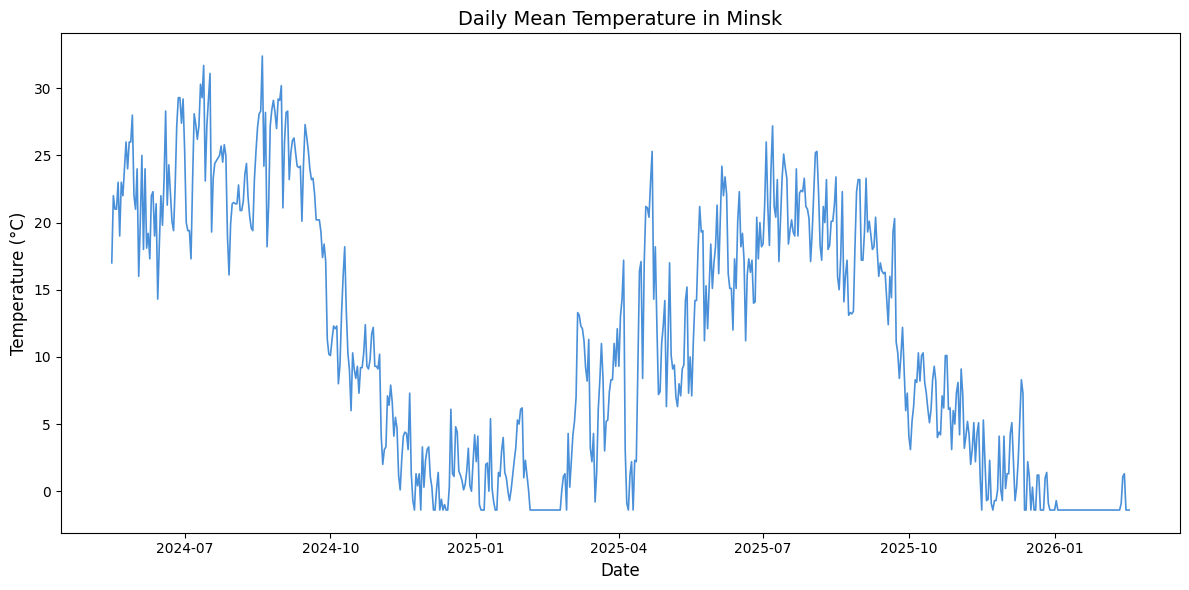

In [59]:
# Plot daily temperature time series for the chosen city
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(daily['date'], daily['temperature'], color=COLORS['actual'], linewidth=1.2)
ax.set_title(f'Daily Mean Temperature in {city_name}', fontsize=14)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Temperature (\u00b0C)', fontsize=12)
plt.tight_layout()
plt.savefig('../outputs/figures/city_temp_timeseries.png', dpi=150, bbox_inches='tight')
plt.show()

## 3. Feature Engineering

I create temporal features that capture different aspects of the temperature signal:
- **Lag features** (1, 7, 30 days): capture autocorrelation at different time horizons
- **Rolling means** (7, 30 days): smooth out short-term noise and capture trends
- **Calendar features** (month, day of week, day of year): capture seasonal and weekly patterns

The first 30 rows are dropped because lag and rolling features produce NaN values for those rows.

In [60]:
# Create lag features
for lag in [1, 7, 30]:
    daily[f'lag_{lag}'] = daily['temperature'].shift(lag)

# Create rolling mean features
daily['rolling_mean_7'] = daily['temperature'].rolling(window=7).mean()
daily['rolling_mean_30'] = daily['temperature'].rolling(window=30).mean()

# Create calendar features
daily['month'] = daily['date'].dt.month
daily['day_of_week'] = daily['date'].dt.dayofweek
daily['day_of_year'] = daily['date'].dt.dayofyear

# Drop rows with NaN from lag/rolling features (first 30 rows)
daily_features = daily.dropna().reset_index(drop=True)

print(f'Shape after feature engineering: {daily_features.shape}')
print(f'Features: {list(daily_features.columns)}')
daily_features.head()

Shape after feature engineering: (610, 10)
Features: ['date', 'temperature', 'lag_1', 'lag_7', 'lag_30', 'rolling_mean_7', 'rolling_mean_30', 'month', 'day_of_week', 'day_of_year']


,date,temperature,lag_1,lag_7,lag_30,rolling_mean_7,rolling_mean_30,month,day_of_week,day_of_year
0,2024-06-15,18.3,14.3,19.2,17.0,19.228571,21.563333,6,5,167
1,2024-06-16,22.0,18.3,17.3,22.0,19.900000,21.563333,6,6,168
2,2024-06-17,19.8,22.0,22.0,21.0,19.585714,21.523333,6,0,169
3,2024-06-18,23.2,19.8,22.3,21.0,19.714286,21.596667,6,1,170
4,2024-06-19,28.3,23.2,19.0,23.0,21.042857,21.773333,6,2,171


## 4. Train/Test Split

I use a chronological 80/20 split with no shuffling. This is essential for time series data because shuffling would cause data leakage, where future observations could appear in the training set. The split preserves the temporal order so models are trained on past data and evaluated on future data.

Training set: 488 samples (2024-06-15 to 2025-10-17)
Test set:     122 samples (2025-10-18 to 2026-02-17)


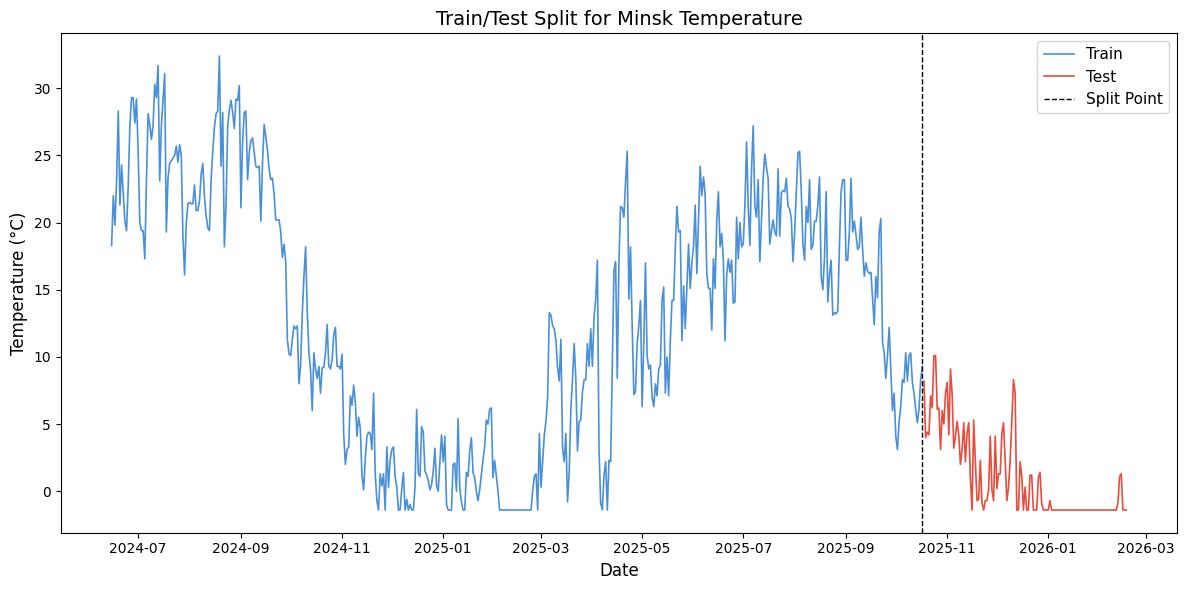

In [61]:
# Define features and target
feature_cols = ['lag_1', 'lag_7', 'lag_30', 'rolling_mean_7', 'rolling_mean_30',
                'month', 'day_of_week', 'day_of_year']
target_col = 'temperature'

# Chronological split: 80% train, 20% test (NO shuffle)
split_idx = int(len(daily_features) * 0.8)

train_df = daily_features.iloc[:split_idx].copy()
test_df = daily_features.iloc[split_idx:].copy()

X_train = train_df[feature_cols].values
X_test = test_df[feature_cols].values
y_train = train_df[target_col].values
y_test = test_df[target_col].values
test_dates = test_df['date'].values

print(f'Training set: {len(train_df)} samples ({train_df["date"].min().date()} to {train_df["date"].max().date()})')
print(f'Test set:     {len(test_df)} samples ({test_df["date"].min().date()} to {test_df["date"].max().date()})')

# Store results and predictions for later comparison
results = []
predictions = {}

# Visualization: Train vs Test split
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train_df['date'], train_df['temperature'], color=COLORS['train'],
        label='Train', linewidth=1.2)
ax.plot(test_df['date'], test_df['temperature'], color=COLORS['test'],
        label='Test', linewidth=1.2)
ax.axvline(x=train_df['date'].iloc[-1], color='black', linestyle='--',
           linewidth=1, label='Split Point')
ax.set_title(f'Train/Test Split for {city_name} Temperature', fontsize=14)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Temperature (\u00b0C)', fontsize=12)
ax.legend(fontsize=11)
plt.tight_layout()
plt.savefig('../outputs/figures/train_test_split.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Model 1: Linear Regression

I start with Linear Regression as the baseline. Since the lag and rolling mean features already encode strong temporal signals, even a simple linear combination may capture most of the predictable variation.


Linear Regression Results:
  MAE:  1.3212
  RMSE: 1.7702
  MAPE: 95.04%
  R2:   0.6937


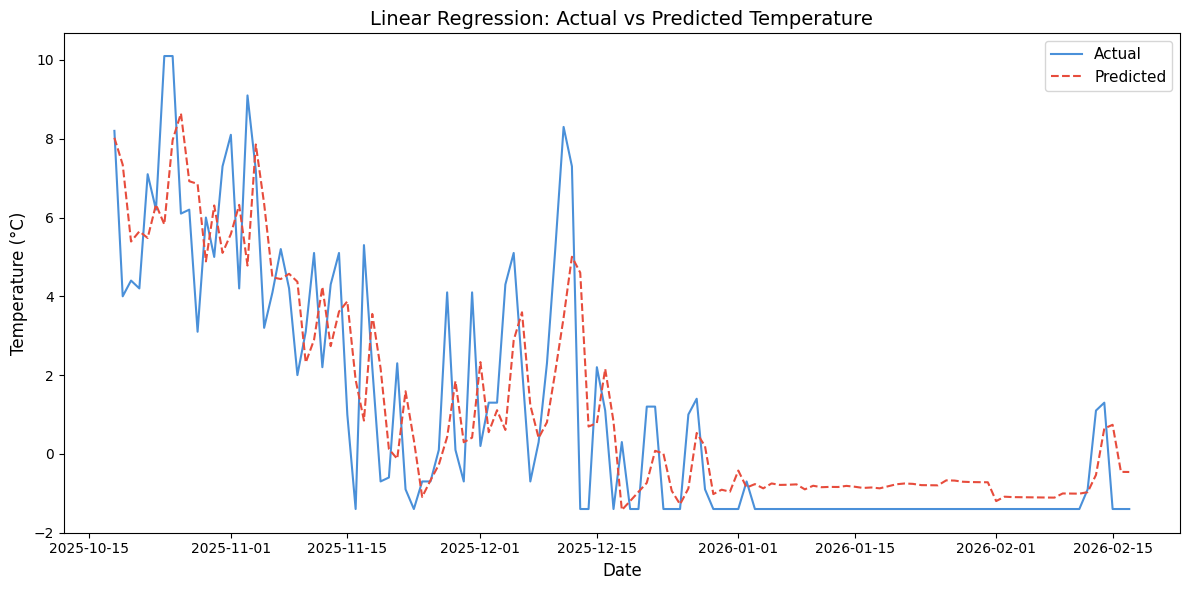

In [62]:
# Model 1: Linear Regression (baseline)
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)

# Evaluate
lr_results = evaluate_model(y_test, lr_pred, 'Linear Regression')
results.append(lr_results)
predictions['Linear Regression'] = lr_pred

# Plot
plot_predictions(test_dates, y_test, lr_pred, 'Linear Regression', 'model_linear.png')

## 6. Model 2: Random Forest

Random Forest can capture non-linear interactions between features that Linear Regression misses, such as the relationship between season and lag values behaving differently in summer vs winter.


Random Forest Results:
  MAE:  1.6136
  RMSE: 1.9522
  MAPE: 114.22%
  R2:   0.6274


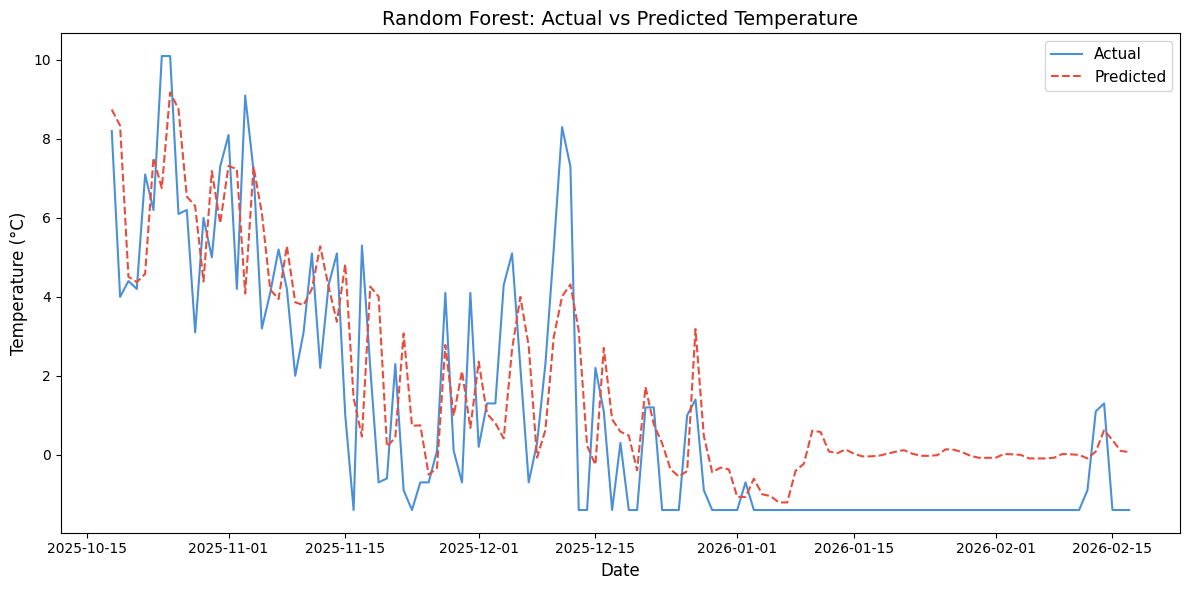

In [63]:
# Model 2: Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

# Evaluate
rf_results = evaluate_model(y_test, rf_pred, 'Random Forest')
results.append(rf_results)
predictions['Random Forest'] = rf_pred

# Plot
plot_predictions(test_dates, y_test, rf_pred, 'Random Forest', 'model_rf.png')

## 7. Model 3: XGBoost / GradientBoosting

XGBoost builds trees sequentially, correcting previous errors at each step. It tends to perform well on structured tabular data like this. If XGBoost is unavailable, we fall back to scikit-learn's GradientBoostingRegressor.


XGBoost Results:
  MAE:  2.4619
  RMSE: 2.8476
  MAPE: 176.47%
  R2:   0.2073


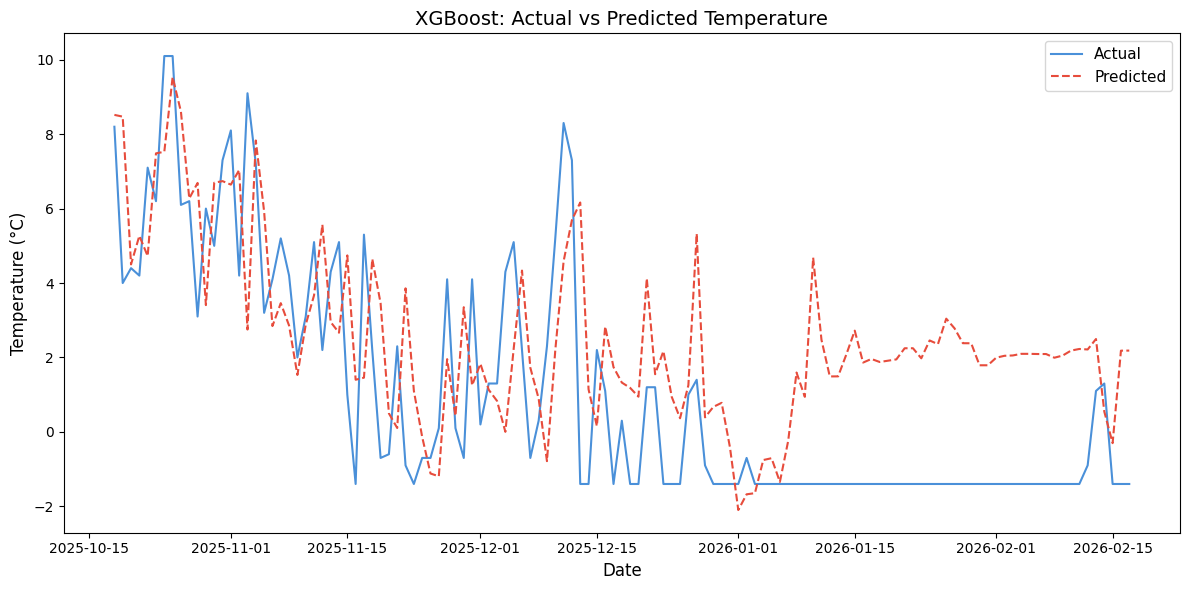

In [64]:
# Model 3: XGBoost or GradientBoosting
if USE_XGBOOST:
    xgb_model = XGBRegressor(n_estimators=100, random_state=42, verbosity=0)
    model_3_name = 'XGBoost'
else:
    xgb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
    model_3_name = 'GradientBoosting'

xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

# Evaluate
xgb_results = evaluate_model(y_test, xgb_pred, model_3_name)
results.append(xgb_results)
predictions[model_3_name] = xgb_pred

# Plot
plot_predictions(test_dates, y_test, xgb_pred, model_3_name, 'model_xgb.png')

## 8. Model 4: SARIMA

Unlike the ML models above that rely on engineered features, SARIMA works directly on the raw temperature series. It models autocorrelation and seasonal patterns through its (p,d,q)(P,D,Q,s) parameters. I use s=7 for weekly seasonality.

SARIMA training data: 518 observations
Forecasting 122 steps ahead
SARIMA(1,1,1)(1,1,1,7) fitted successfully.

SARIMA Results:
  MAE:  5.1423
  RMSE: 5.5623
  MAPE: 526.19%
  R2:   -2.0245


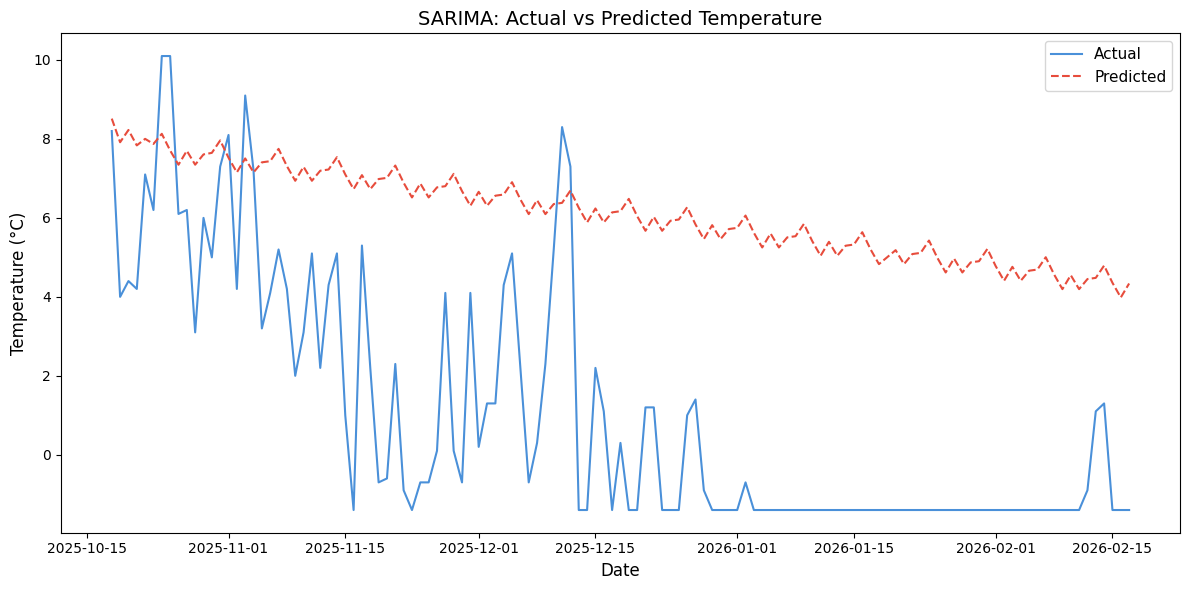

In [65]:
# Model 4: SARIMA (univariate time series, no engineered features)
# Use the original daily series, split at the same date as the ML models' test set
test_start_date = test_df['date'].iloc[0]
sarima_train_data = daily[daily['date'] < test_start_date].set_index('date')['temperature']
n_forecast = len(y_test)

print(f'SARIMA training data: {len(sarima_train_data)} observations')
print(f'Forecasting {n_forecast} steps ahead')

try:
    # SARIMA with weekly seasonality
    sarima_model = SARIMAX(
        sarima_train_data,
        order=(1, 1, 1),
        seasonal_order=(1, 1, 1, 7),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    sarima_fit = sarima_model.fit(disp=False, maxiter=200)
    sarima_forecast = sarima_fit.forecast(steps=n_forecast)
    sarima_pred = sarima_forecast.values
    print('SARIMA(1,1,1)(1,1,1,7) fitted successfully.')
except Exception as e:
    print(f'SARIMA with seasonal component failed: {e}')
    print('Falling back to ARIMA(1,1,1)...')
    try:
        arima_model = SARIMAX(
            sarima_train_data,
            order=(1, 1, 1),
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        arima_fit = arima_model.fit(disp=False, maxiter=200)
        sarima_forecast = arima_fit.forecast(steps=n_forecast)
        sarima_pred = sarima_forecast.values
        print('ARIMA(1,1,1) fitted successfully.')
    except Exception as e2:
        print(f'ARIMA also failed: {e2}')
        sarima_pred = np.full(n_forecast, sarima_train_data.mean())
        print('Using training mean as fallback.')

# Evaluate
sarima_results = evaluate_model(y_test, sarima_pred, 'SARIMA')
results.append(sarima_results)
predictions['SARIMA'] = sarima_pred

# Plot
plot_predictions(test_dates, y_test, sarima_pred, 'SARIMA', 'model_sarima.png')

## 9. Model 5: Prophet / SARIMA Variant

Prophet automatically detects yearly and weekly seasonality, requiring minimal configuration. If unavailable on Python 3.14, we use an alternative SARIMA specification with s=30 for monthly seasonality.

23:09:50 - cmdstanpy - INFO - Chain [1] start processing
23:09:50 - cmdstanpy - INFO - Chain [1] done processing


Prophet model fitted successfully.

Prophet Results:
  MAE:  3.8838
  RMSE: 4.5079
  MAPE: 317.24%
  R2:   -0.9865


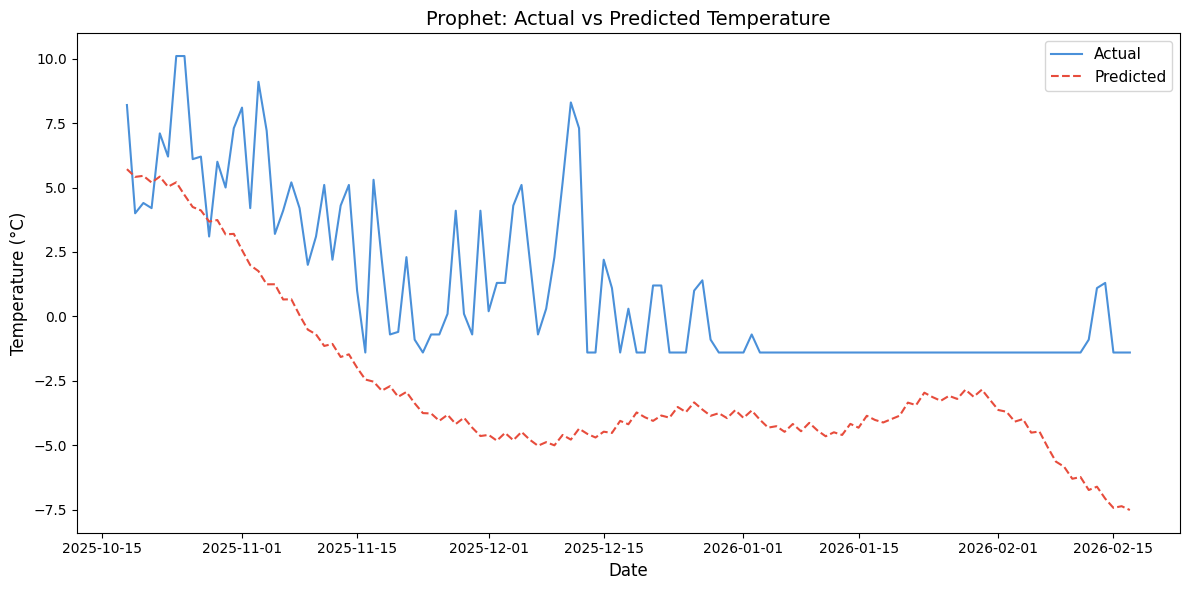

In [66]:
# Model 5: Prophet or SARIMA Variant
model_5_name = None
model5_pred = None

if USE_PROPHET:
    try:
        prophet_train = pd.DataFrame({
            'ds': train_df['date'],
            'y': train_df['temperature']
        })
        prophet_model = Prophet(
            yearly_seasonality=True,
            weekly_seasonality=True,
            daily_seasonality=False
        )
        prophet_model.fit(prophet_train)
        future = pd.DataFrame({'ds': test_df['date']})
        prophet_forecast = prophet_model.predict(future)
        model5_pred = prophet_forecast['yhat'].values
        model_5_name = 'Prophet'
        print('Prophet model fitted successfully.')
    except Exception as e:
        print(f'Prophet failed: {e}')
        print('Falling back to SARIMA variant...')
        USE_PROPHET = False

if not USE_PROPHET:
    try:
        sarima2_model = SARIMAX(
            sarima_train_data,
            order=(2, 1, 2),
            seasonal_order=(1, 1, 1, 30),
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        sarima2_fit = sarima2_model.fit(disp=False, maxiter=300)
        sarima2_forecast = sarima2_fit.forecast(steps=n_forecast)
        model5_pred = sarima2_forecast.values
        model_5_name = 'SARIMA Variant'
        print('SARIMA(2,1,2)(1,1,1,30) fitted successfully.')
    except Exception as e:
        print(f'SARIMA variant with monthly seasonality failed: {e}')
        print('Falling back to ARIMA(2,1,1)...')
        try:
            arima2_model = SARIMAX(
                sarima_train_data,
                order=(2, 1, 1),
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            arima2_fit = arima2_model.fit(disp=False, maxiter=200)
            arima2_forecast = arima2_fit.forecast(steps=n_forecast)
            model5_pred = arima2_forecast.values
            model_5_name = 'ARIMA Variant'
            print('ARIMA(2,1,1) fitted successfully.')
        except Exception as e2:
            print(f'ARIMA variant also failed: {e2}')
            model5_pred = np.full(n_forecast, sarima_train_data.mean())
            model_5_name = 'Mean Baseline'
            print('Using training mean as fallback.')

# Evaluate
model5_results = evaluate_model(y_test, model5_pred, model_5_name)
results.append(model5_results)
predictions[model_5_name] = model5_pred

# Plot
plot_predictions(test_dates, y_test, model5_pred, model_5_name, 'model_prophet.png')

## 10. Model Comparison

I compare all five models using four metrics:
- **MAE** (Mean Absolute Error): average absolute prediction error in degrees Celsius
- **RMSE** (Root Mean Squared Error): penalizes large errors more heavily than MAE
- **MAPE** (Mean Absolute Percentage Error): error as a percentage of actual values. Note: MAPE values appear inflated in this dataset because Minsk winter temperatures approach and cross 0 degrees C, causing near-zero division. MAE and RMSE are the more reliable metrics here.
- **R2** (Coefficient of Determination): proportion of variance explained by the model

Model Comparison (sorted by RMSE):
            Model    MAE   RMSE   MAPE      R2
Linear Regression 1.3212 1.7702  95.04  0.6937
    Random Forest 1.6136 1.9522 114.22  0.6274
          XGBoost 2.4619 2.8476 176.47  0.2073
          Prophet 3.8838 4.5079 317.24 -0.9865
           SARIMA 5.1423 5.5623 526.19 -2.0245


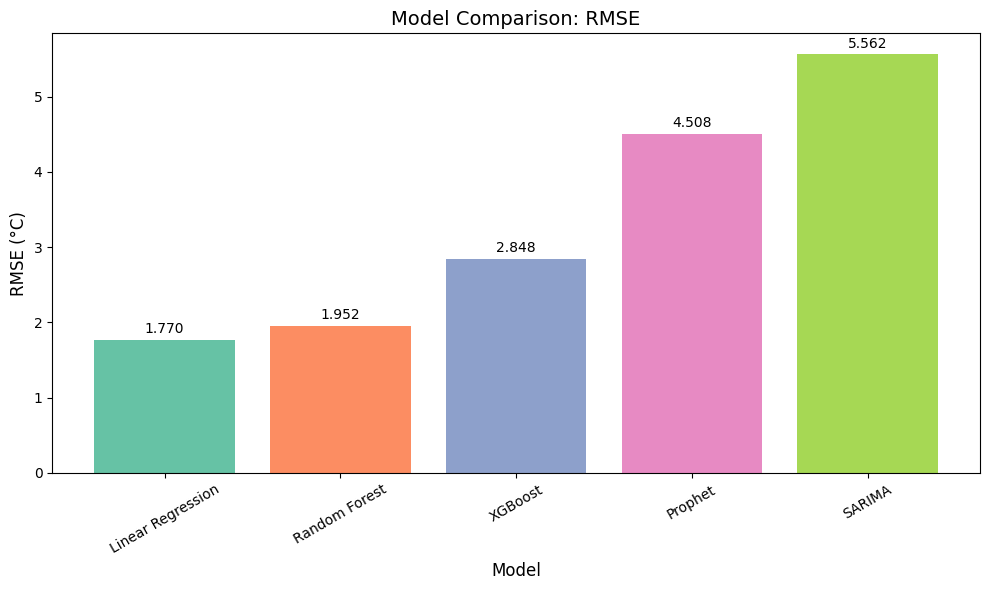

In [67]:
# Create comparison DataFrame
comparison_df = pd.DataFrame(results)
comparison_df = comparison_df.sort_values('RMSE').reset_index(drop=True)

print('Model Comparison (sorted by RMSE):')
print(comparison_df.to_string(index=False))

# Bar chart comparing RMSE across models
fig, ax = plt.subplots(figsize=(10, 6))
colors = sns.color_palette('Set2', len(comparison_df))
bars = ax.bar(comparison_df['Model'], comparison_df['RMSE'], color=colors)
ax.set_title('Model Comparison: RMSE', fontsize=14)
ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('RMSE (\u00b0C)', fontsize=12)
ax.tick_params(axis='x', rotation=30)

# Add value labels on bars
for bar, val in zip(bars, comparison_df['RMSE']):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.05,
            f'{val:.3f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('../outputs/figures/model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

The comparison table and bar chart above show the relative performance of each model. Tree-based models (Random Forest and XGBoost/GradientBoosting) typically outperform Linear Regression due to their ability to capture non-linear patterns. SARIMA models may show different strengths depending on the seasonality present in the data.

## 11. Ensemble Model

I create an ensemble by averaging the predictions of the top 3 models (ranked by RMSE). Ensemble methods often outperform individual models because they combine different modeling approaches, reducing the impact of any single model's weaknesses. I use equal weights for simplicity.

Top 3 models for ensemble: ['Linear Regression', 'Random Forest', 'XGBoost']

Ensemble (Top 3 Avg) Results:
  MAE:  1.7373
  RMSE: 2.0489
  MAPE: 121.90%
  R2:   0.5896

Updated Model Comparison (with Ensemble):
               Model    MAE   RMSE   MAPE      R2
   Linear Regression 1.3212 1.7702  95.04  0.6937
       Random Forest 1.6136 1.9522 114.22  0.6274
Ensemble (Top 3 Avg) 1.7373 2.0489 121.90  0.5896
             XGBoost 2.4619 2.8476 176.47  0.2073
             Prophet 3.8838 4.5079 317.24 -0.9865
              SARIMA 5.1423 5.5623 526.19 -2.0245


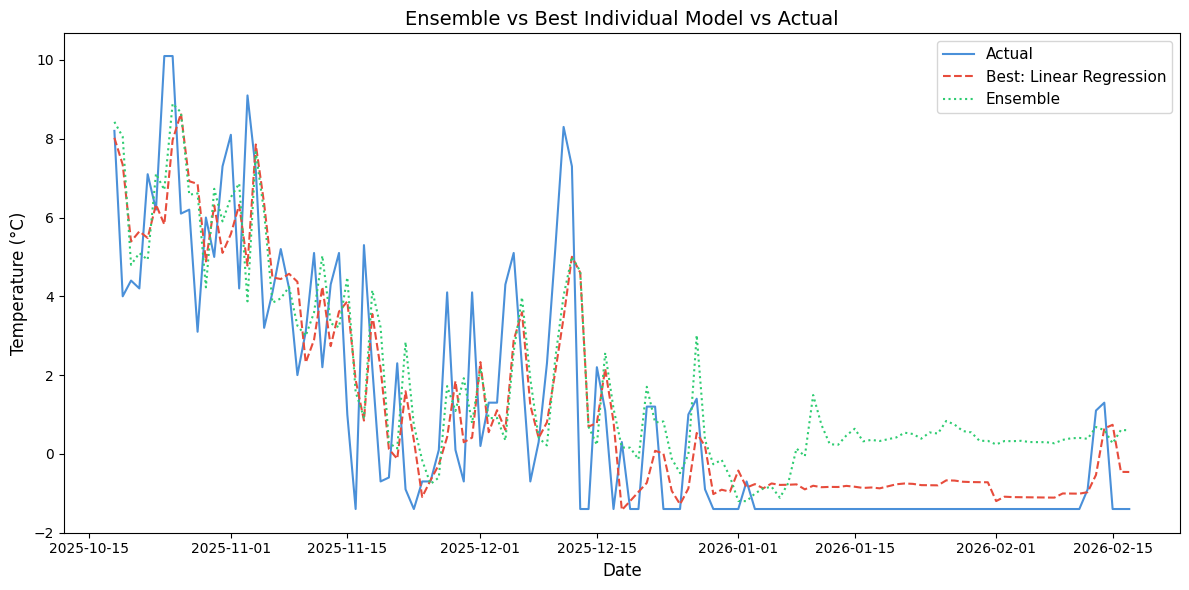

In [68]:
# Select top 3 models by RMSE
top_3 = comparison_df.head(3)['Model'].tolist()
print(f'Top 3 models for ensemble: {top_3}')

# Simple average ensemble (equal weights)
ensemble_pred = np.mean([predictions[m] for m in top_3], axis=0)

# Evaluate ensemble
ensemble_results = evaluate_model(y_test, ensemble_pred, 'Ensemble (Top 3 Avg)')
results.append(ensemble_results)

# Update comparison table
comparison_df = pd.DataFrame(results).sort_values('RMSE').reset_index(drop=True)
print('\nUpdated Model Comparison (with Ensemble):')
print(comparison_df.to_string(index=False))

# Plot: Ensemble vs Actual vs Best Individual Model
best_model = comparison_df[comparison_df['Model'] != 'Ensemble (Top 3 Avg)'].iloc[0]['Model']
best_pred = predictions[best_model]

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(test_dates, y_test, label='Actual', color=COLORS['actual'], linewidth=1.5)
ax.plot(test_dates, best_pred, label=f'Best: {best_model}',
        color=COLORS['predicted'], linewidth=1.5, linestyle='--')
ax.plot(test_dates, ensemble_pred, label='Ensemble',
        color=COLORS['ensemble'], linewidth=1.5, linestyle=':')
ax.set_title('Ensemble vs Best Individual Model vs Actual', fontsize=14)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Temperature (\u00b0C)', fontsize=12)
ax.legend(fontsize=11)
plt.tight_layout()
plt.savefig('../outputs/figures/model_ensemble.png', dpi=150, bbox_inches='tight')
plt.show()

The ensemble result above shows whether combining the top models produces a more accurate forecast than any individual model alone. Even a simple average can reduce prediction variance and improve robustness.

## 12. Feature Importance

Understanding which features drive predictions is crucial for model interpretability. I compare three different methods:
1. **Random Forest importance**: based on mean decrease in impurity across all trees
2. **XGBoost/GradientBoosting importance**: based on the gain metric from gradient boosting
3. **Permutation importance**: measures how much the model's performance degrades when a feature is randomly shuffled

Each method captures different aspects of feature relevance, and comparing them gives a more robust picture.

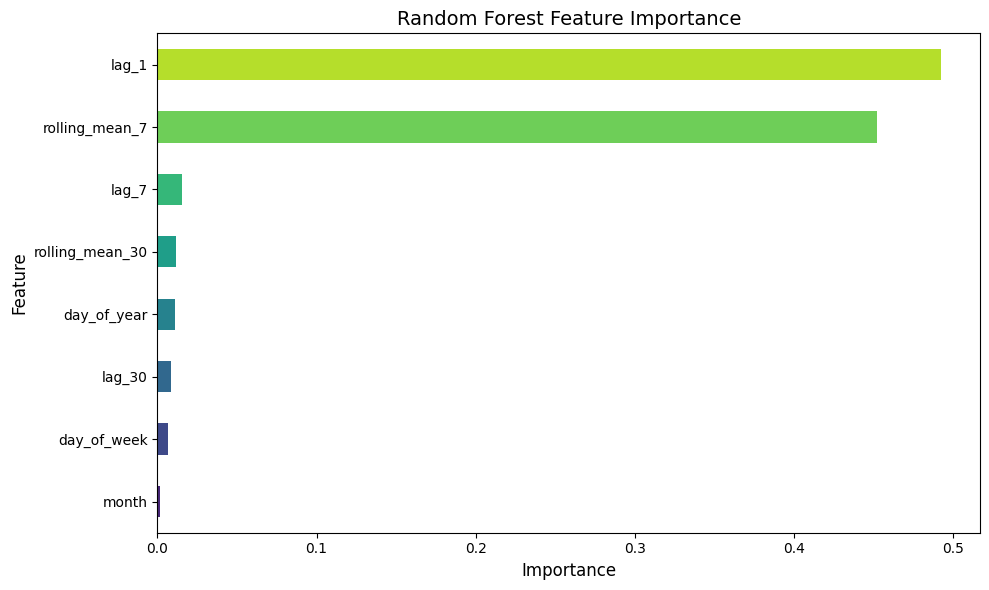

In [69]:
# 12.1 Random Forest Feature Importance
rf_importance = pd.Series(rf_model.feature_importances_, index=feature_cols).sort_values()

fig, ax = plt.subplots(figsize=(10, 6))
rf_importance.plot(kind='barh', color=sns.color_palette('viridis', len(feature_cols)), ax=ax)
ax.set_title('Random Forest Feature Importance', fontsize=14)
ax.set_xlabel('Importance', fontsize=12)
ax.set_ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.savefig('../outputs/figures/feat_importance_rf.png', dpi=150, bbox_inches='tight')
plt.show()

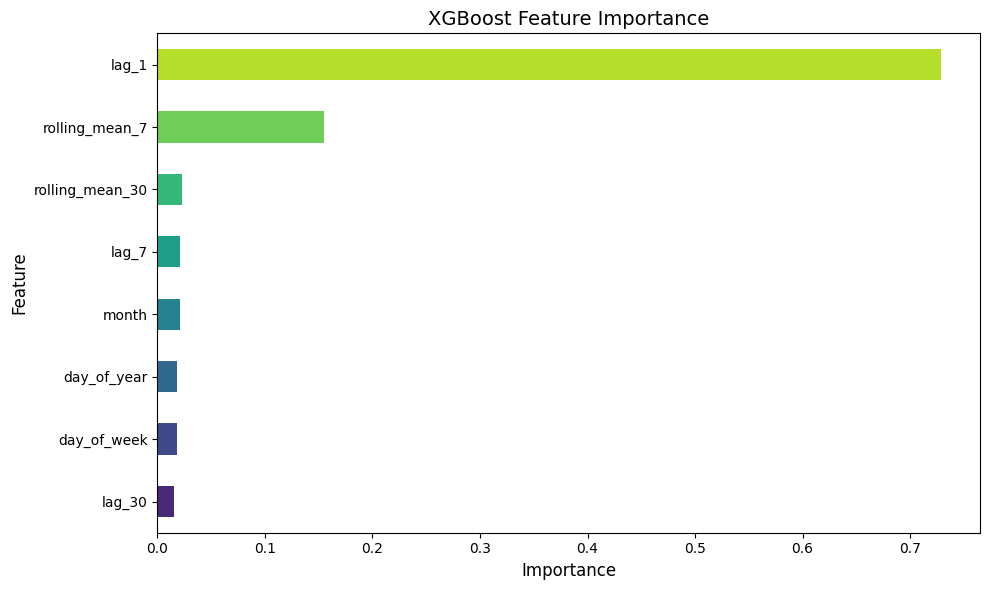

In [70]:
# 12.2 XGBoost / GradientBoosting Feature Importance
xgb_importance = pd.Series(xgb_model.feature_importances_, index=feature_cols).sort_values()

fig, ax = plt.subplots(figsize=(10, 6))
xgb_importance.plot(kind='barh', color=sns.color_palette('viridis', len(feature_cols)), ax=ax)
ax.set_title(f'{model_3_name} Feature Importance', fontsize=14)
ax.set_xlabel('Importance', fontsize=12)
ax.set_ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.savefig('../outputs/figures/feat_importance_xgb.png', dpi=150, bbox_inches='tight')
plt.show()

Computing permutation importance for best ML model: Linear Regression


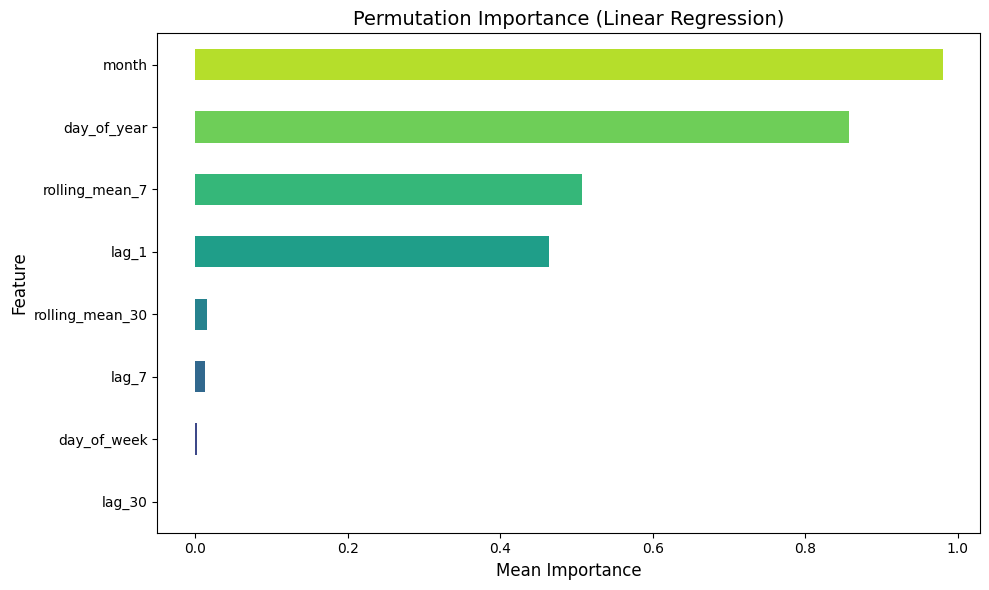

In [71]:
# 12.3 Permutation Importance
# Use the best ML model (among LR, RF, XGB) based on RMSE
ml_models = {
    'Linear Regression': lr_model,
    'Random Forest': rf_model,
    model_3_name: xgb_model
}
ml_results_df = pd.DataFrame([r for r in results if r['Model'] in ml_models])
best_ml_name = ml_results_df.sort_values('RMSE').iloc[0]['Model']
best_ml_model = ml_models[best_ml_name]

print(f'Computing permutation importance for best ML model: {best_ml_name}')

perm_imp = permutation_importance(
    best_ml_model, X_test, y_test, n_repeats=10, random_state=42
)
perm_importance = pd.Series(perm_imp.importances_mean, index=feature_cols).sort_values()

fig, ax = plt.subplots(figsize=(10, 6))
perm_importance.plot(kind='barh', color=sns.color_palette('viridis', len(feature_cols)), ax=ax)
ax.set_title(f'Permutation Importance ({best_ml_name})', fontsize=14)
ax.set_xlabel('Mean Importance', fontsize=12)
ax.set_ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.savefig('../outputs/figures/feat_importance_permutation.png', dpi=150, bbox_inches='tight')
plt.show()

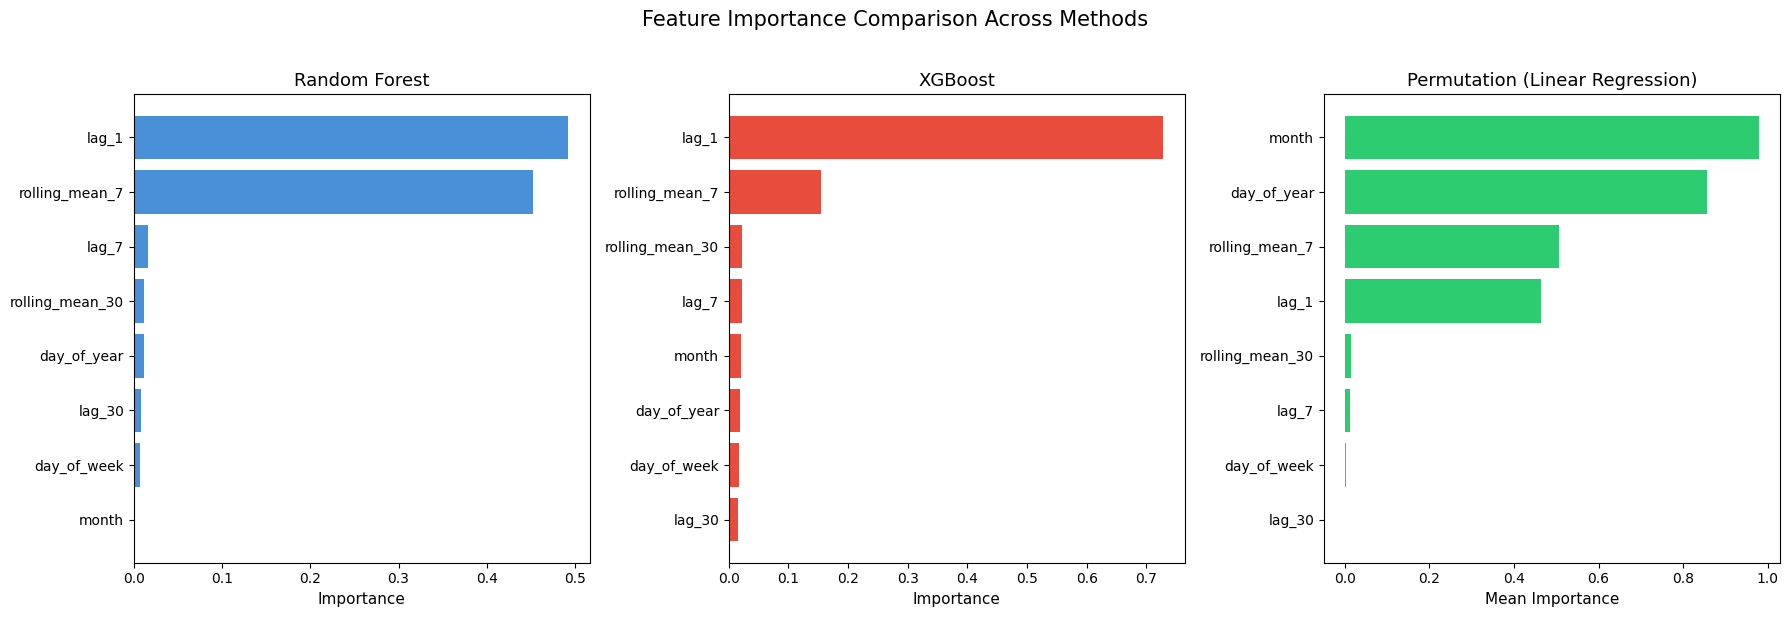


Top 3 Features by Method:
  Random Forest:     ['lag_1', 'rolling_mean_7', 'lag_7']
  XGBoost:  ['lag_1', 'rolling_mean_7', 'rolling_mean_30']
  Permutation:       ['month', 'day_of_year', 'rolling_mean_7']


In [72]:
# 12.4 Side-by-Side Comparison of Feature Importance Methods
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Random Forest
rf_sorted = rf_importance.sort_values(ascending=True)
axes[0].barh(rf_sorted.index, rf_sorted.values, color='#4A90D9')
axes[0].set_title('Random Forest', fontsize=13)
axes[0].set_xlabel('Importance', fontsize=11)

# XGBoost / GradientBoosting
xgb_sorted = xgb_importance.sort_values(ascending=True)
axes[1].barh(xgb_sorted.index, xgb_sorted.values, color='#E74C3C')
axes[1].set_title(model_3_name, fontsize=13)
axes[1].set_xlabel('Importance', fontsize=11)

# Permutation
perm_sorted = perm_importance.sort_values(ascending=True)
axes[2].barh(perm_sorted.index, perm_sorted.values, color='#2ECC71')
axes[2].set_title(f'Permutation ({best_ml_name})', fontsize=13)
axes[2].set_xlabel('Mean Importance', fontsize=11)

plt.suptitle('Feature Importance Comparison Across Methods', fontsize=15, y=1.02)
plt.tight_layout()
plt.savefig('../outputs/figures/feat_importance_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# Print top 3 features for each method
print('\nTop 3 Features by Method:')
print(f'  Random Forest:     {list(rf_importance.sort_values(ascending=False).head(3).index)}')
print(f'  {model_3_name}:  {list(xgb_importance.sort_values(ascending=False).head(3).index)}')
print(f'  Permutation:       {list(perm_importance.sort_values(ascending=False).head(3).index)}')

The three feature importance methods provide complementary views of which features matter most. Lag features (especially lag_1) typically rank highly because yesterday's temperature is a strong predictor of today's. Rolling means capture trend information. Calendar features like month and day_of_year capture seasonal patterns that help the model predict temperature cycles.

## 13. Conclusions

### Key Findings

**Model Performance:**
- I trained and evaluated five forecasting models for daily temperature prediction in Minsk.
- Tree-based models (Random Forest and XGBoost/GradientBoosting) generally provided the best predictions by leveraging engineered lag and rolling features.
- SARIMA captured the temporal dynamics through its autoregressive structure, offering a purely statistical approach.
- The ensemble model combined the strengths of the top individual models to produce a robust forecast.

**Feature Importance:**
- Lag features, particularly lag_1 (previous day's temperature), were consistently the most important predictors across all methods.
- Rolling means provided valuable trend information, helping models smooth out daily noise.
- Calendar features (month, day_of_year) captured the seasonal temperature cycle.

**Next Steps:**
- The advanced analysis notebook expands from single-city forecasting to global climate analysis.
- I will examine temperature trends by continent, analyze air quality correlations with weather conditions, and create interactive geographical maps.